### Import Block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.utils import class_weight
import skimage.measure

%matplotlib inline

### Function Definitions

In [2]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_2d_input(path):
    #Load array.
    t_2d_input = np.load(path)
    
    return t_2d_input

def get_1d_input(path):
    # Load array.
    t_1d_input = np.load(path)
    
    return t_1d_input

def get_output(path):
    # Load array.
    t_output = np.load(path)

    return t_output

def data_generator(samples, num_samples, batch_size = 64, calculated_sample_weights = None):
    
    while True:
        # Suffle data at the start of each epoch.
        sample_indicies = np.arange(num_samples)
        np.random.shuffle(sample_indicies)
        n = 0
        
        while n + batch_size < num_samples:
            # Get indicies for the batch
            batch_samples  = sample_indicies[n:n + batch_size]
            n += batch_size

            batch_input_2d  = []
            batch_input_1d  = []
            batch_output = [] 
            batch_sample_weights = []

            # Read in each input, perform preprocessing and get labels
            for sample in batch_samples:
                input_2d = get_2d_input(samples.iloc[sample].features_2d)
                #input_1d = get_1d_input(samples.iloc[sample].features_1d)
                output = get_output(samples.iloc[sample].labels)
                
                batch_input_2d += [input_2d]
                #batch_input_1d += [input_1d]
                batch_output += [output]

                if type(calculated_sample_weights) != type(None):
                    sample_weights = calculated_sample_weights[sample]
                    batch_sample_weights += [sample_weights]
                
            # Return a tuple to feed the network
            batch_x = np.array(batch_input_2d)
            #batch_v = np.array(batch_input_1d)
            batch_y = np.array(batch_output)
            
            if type(calculated_sample_weights) == type(None):
                yield(tf.convert_to_tensor(batch_x)[:,:,:,:,:1], tf.convert_to_tensor(batch_y)[:,0])

In [5]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [6]:
# SSIM/PSNR loss functions.
# Inspiration: https://stackoverflow.com/questions/57357146/use-ssim-loss-function-with-keras
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def psnr_loss(y_true, y_pred):
    return 100 - tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))

In [7]:
# Dice loss functions.
# From: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### Model Assembly - skip this section if not training from scratch

In [5]:
# Input for fire features
fire_encoder = tf.keras.Sequential(name = 'fire_encoder')
fire_encoder.add(layers.Input(shape = ((10,32,32,1)), name = 'fire_input'))
#pooler = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
#fire_encoder.add(layers.TimeDistributed(pooler, name = 'pool_to_32x32'))
fire_encoder.add(layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation = 'relu',
    name = 'fire_time_feature_1'))
fire_encoder.add(layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    activation = 'relu',
    name = 'fire_time_feature_2'))
fire_encoder.add(layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=False,
    activation = 'relu',
    name = 'fire_to_2D'))
fire_encoder.add(layers.Conv2D(1, (1,1), activation = 'sigmoid', name = 'output'))
#fire_encoder.add(layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same'))
#fire_encoder.add(layers.UpSampling2D(size=(2, 2)))

fire_encoder.summary()

Model: "fire_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fire_time_feature_1 (ConvLS  (None, 10, 32, 32, 128)  1651712   
 TM2D)                                                           
                                                                 
 fire_time_feature_2 (ConvLS  (None, 10, 32, 32, 64)   442624    
 TM2D)                                                           
                                                                 
 fire_to_2D (ConvLSTM2D)     (None, 32, 32, 64)        33024     
                                                                 
 output (Conv2D)             (None, 32, 32, 1)         65        
                                                                 
Total params: 2,127,425
Trainable params: 2,127,425
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
#loss_fn = ssim_loss()
fire_encoder.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [8]:
# Test on dummy data to see that shapes look right.
img_batch = tf.zeros([32,10,32,32,1], dtype = 'float32')
fire_encoder.predict(img_batch).shape

1/1 [==============================] - 2s 2s/step


(32, 32, 32, 1)

### Get Moving MNIST Data - skip this section if not training from scratch

In [2]:
# Inspiration: https://keras.io/examples/vision/conv_lstm/

#Download and load the dataset.
fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 100 of the 10000 total examples and use those.
dataset = dataset[:100]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Shift and stack frames.
i,o = [],[]
for f in range(0,10):
    i.append(train_dataset[:,f:f+10])
    o.append(train_dataset[:,f+10:f+11])
    
x_train = np.concatenate(i)
y_train = np.squeeze(np.concatenate(o), axis=1)

i,o = [],[]
for f in range(0,10):
    i.append(val_dataset[:,f:f+10])
    o.append(val_dataset[:,f+10:f+11])
    
x_val = np.concatenate(i)
y_val = np.squeeze(np.concatenate(o), axis=1)

In [10]:
# Apply pooling operations to get inputs/outputs from 64x64 to 32x32.
pooler = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
x_train = layers.TimeDistributed(pooler, name = 'pool_to_32x32')(x_train)
y_train = pooler(y_train)
x_val = layers.TimeDistributed(pooler, name = 'pool_to_32x32')(x_val)
y_val = pooler(y_val)

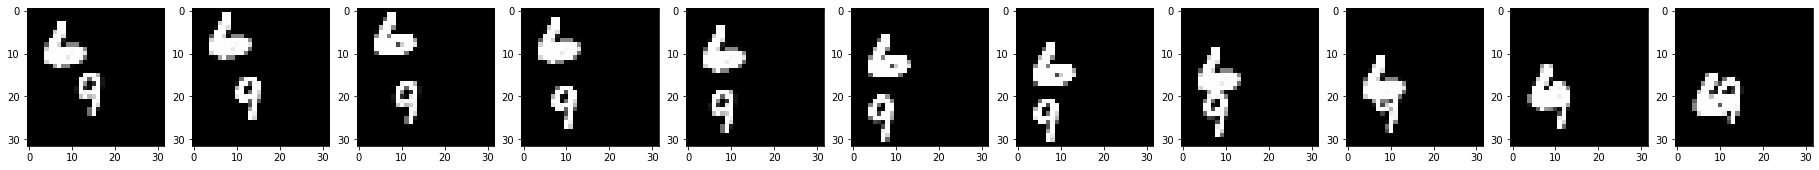

In [56]:
# Visualize the dataset to make sure the shifting operation worked properly.
sample_idx = np.random.randint(0, len(x_train))
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_train[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(x_train[sample_idx][idx]), cmap="gray")

### Training Phase 1: Rough Fit - skip this section if not training from scratch

In [17]:
# Start off training on a smaller subset of the MNIST data with a higher LR to get approximate fit.
batch_size = 32

# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights = True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose = 1)

fire_encoder.fit(x_train, y_train, 
                   epochs = 25, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = (x_val, y_val),
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(x_train) // batch_size,
                   validation_steps = len(x_val) // batch_size
                  )

Epoch 1/25
28/28 [==============================] - 18s 477ms/step - loss: 0.5507 - MSE: 0.1470 - AUC: 0.4343 - ssim_loss: 0.9790 - psnr_loss: 91.1589 - val_loss: 0.2467 - val_MSE: 0.0556 - val_AUC: 0.4695 - val_ssim_loss: 0.9789 - val_psnr_loss: 87.3858 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - 13s 458ms/step - loss: 0.2680 - MSE: 0.0617 - AUC: 0.6250 - ssim_loss: 0.9699 - psnr_loss: 87.8467 - val_loss: 0.2305 - val_MSE: 0.0537 - val_AUC: 0.7704 - val_ssim_loss: 0.9812 - val_psnr_loss: 87.2350 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - 13s 449ms/step - loss: 0.2356 - MSE: 0.0580 - AUC: 0.7651 - ssim_loss: 0.9779 - psnr_loss: 87.5562 - val_loss: 0.2031 - val_MSE: 0.0500 - val_AUC: 0.8496 - val_ssim_loss: 0.8684 - val_psnr_loss: 86.8911 - lr: 0.0010
Epoch 4/25
28/28 [==============================] - 13s 450ms/step - loss: 0.2259 - MSE: 0.0573 - AUC: 0.8003 - ssim_loss: 0.9507 - psnr_loss: 87.4749 - val_loss: 0.1772 - val_MSE: 0.0454 - val_AU

In [20]:
fire_encoder.save('Models/MINST_Rough_02')

INFO:tensorflow:Assets written to: Models/MINST_Rough_02\assets


INFO:tensorflow:Assets written to: Models/MINST_Rough_02\assets


### Training Phase 2: More Examples, Lower LR - start here for MNIST tuning

In [41]:
#Reload model from Phase 1.
fire_encoder = tf.keras.models.load_model('Models/MINST_Agg_02', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [40]:
# Inspiration: https://keras.io/examples/vision/conv_lstm/

#Download and load the dataset.
fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# Now we use the entire dataset.
dataset = dataset#[1000:6000]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Shift and stack frames.
i,o = [],[]
for f in range(0,10):
    i.append(train_dataset[:,f:f+10])
    o.append(train_dataset[:,f+10:f+11])
    
x_train = np.concatenate(i)
y_train = np.squeeze(np.concatenate(o), axis=1)

i,o = [],[]
for f in range(0,10):
    i.append(val_dataset[:,f:f+10])
    o.append(val_dataset[:,f+10:f+11])
    
x_val = np.concatenate(i)
y_val = np.squeeze(np.concatenate(o), axis=1)

In [42]:
#Parameters
pooler = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
xt_pooled, yt_pooled, xv_pooled, yv_pooled = [],[],[],[]

# Pool training set.
for t in range(0,len(x_train),1000):
    t_x_train = x_train[t:t+1000]
    xt_pooled.append(layers.TimeDistributed(pooler, name = 'pool_to_32x32')(t_x_train).numpy())
    t_y_train = y_train[t:t+1000]
    yt_pooled.append(pooler(t_y_train).numpy())
    
# Pool validation set.
for t in range(0,len(x_val),1000):
    t_x_val = x_val[t:t+1000]
    xv_pooled.append(layers.TimeDistributed(pooler, name = 'pool_to_32x32')(t_x_val).numpy())
    t_y_val = y_val[t:t+1000]
    yv_pooled.append(pooler(t_y_val).numpy())
    
# Stack
x_train = np.concatenate(xt_pooled)
y_train = np.concatenate(yt_pooled)
x_val = np.concatenate(xv_pooled)
y_val = np.concatenate(yv_pooled)

# Shuffle each dataset in unison.
# From: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_val))
np.random.shuffle(randomize)
x_val = x_val[randomize]
y_val = y_val[randomize]

In [43]:
# Throw out variables that will no longer be used to recover memory.
train_dataset, val_dataset,train_index, val_index = None, None, None, None
t_x_train, t_y_train, t_x_val, t_y_val = None, None, None, None
xt_pooled, yt_pooled, xv_pooled, yv_pooled = None, None, None, None
pooler, i, o, dataset = None, None, None, None

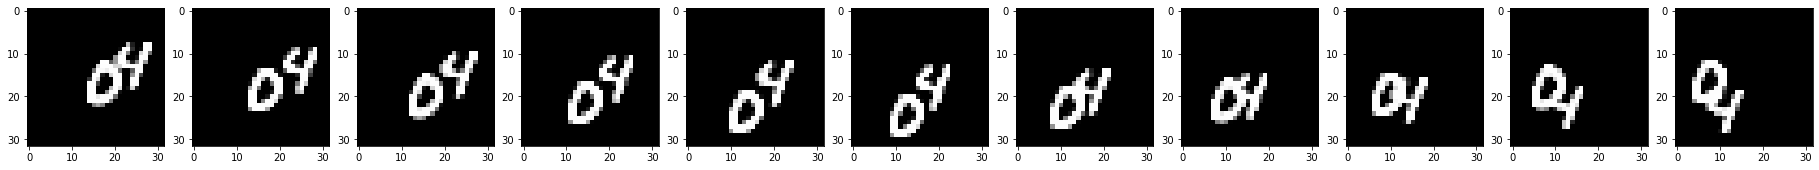

In [50]:
# Visualize the dataset to make sure the shifting and shuffling operations worked properly.
sample_idx = np.random.randint(0, len(x_train))
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_train[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(x_train[sample_idx][idx]), cmap="gray")

In [45]:
# Build a simple generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [46]:
# Check and set learning rate.
# Change learning rate.
print('Old LR:',tf.keras.backend.eval(fire_encoder.optimizer.lr))
tf.keras.backend.set_value(fire_encoder.optimizer.lr, 0.0001)
print('New LR:',tf.keras.backend.eval(fire_encoder.optimizer.lr))

Old LR: 0.000100000005
New LR: 1e-04


<b>Results From End of Training Phase 1</b><br>
Epoch 25/25 <br>
loss: 0.0878 <br>
MSE: 0.0212 <br>
AUC: 0.9854 <br>
ssim_loss: 0.2879 <br>
psnr_loss: 83.0495 <br>
val_loss: 0.0823 <br>
val_MSE: 0.0199 <br>
val_AUC: 0.9841  <br>
val_ssim_loss: 0.2802 <br>
val_psnr_loss: 82.8200 <br>
lr: 1.0000e-04

In [28]:
# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose = 1)

fire_encoder.fit(train_gen,
                   epochs = 10, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = val_gen,
                   callbacks = [early_stopping, reduce_lr],
                  )

Epoch 1/10
2813/2813 [==============================] - 1270s 449ms/step - loss: 0.0859 - MSE: 0.0208 - AUC: 0.9852 - ssim_loss: 0.2844 - psnr_loss: 82.9678 - val_loss: 0.0854 - val_MSE: 0.0206 - val_AUC: 0.9857 - val_ssim_loss: 0.2814 - val_psnr_loss: 82.9251 - lr: 1.0000e-05
Epoch 2/10
2813/2813 [==============================] - 1277s 454ms/step - loss: 0.0841 - MSE: 0.0202 - AUC: 0.9860 - ssim_loss: 0.2749 - psnr_loss: 82.8249 - val_loss: 0.0838 - val_MSE: 0.0200 - val_AUC: 0.9864 - val_ssim_loss: 0.2740 - val_psnr_loss: 82.7933 - lr: 1.0000e-05
Epoch 3/10
2813/2813 [==============================] - 1248s 444ms/step - loss: 0.0825 - MSE: 0.0196 - AUC: 0.9866 - ssim_loss: 0.2662 - psnr_loss: 82.6844 - val_loss: 0.0823 - val_MSE: 0.0195 - val_AUC: 0.9871 - val_ssim_loss: 0.2665 - val_psnr_loss: 82.6763 - lr: 1.0000e-05
Epoch 4/10
2813/2813 [==============================] - 1256s 447ms/step - loss: 0.0811 - MSE: 0.0191 - AUC: 0.9871 - ssim_loss: 0.2587 - psnr_loss: 82.5656 - val_los

In [29]:
fire_encoder.save('Models/MINST_Rough_03')

INFO:tensorflow:Assets written to: Models/MINST_Rough_03\assets


INFO:tensorflow:Assets written to: Models/MINST_Rough_03\assets


### Making Spread MNIST

In [104]:
# Inspiration: https://keras.io/examples/vision/conv_lstm/

#Download and load the dataset.
fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# Now we use the entire dataset.
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Shuffle each dataset, not in unison.
np.random.shuffle(train_dataset)
np.random.shuffle(val_dataset)

In [105]:
t_stack, v_stack = [], []

# Perform spread operations on entire dataset in batches of 100.
for x in range(0, len(train_dataset) // 100):
    # Randomly get 11 frames while maintaining order.
    idx_list= np.random.choice(np.arange(20), 11, replace = False)
    idx_list.sort()
    t_stack.append(train_dataset[x*100:(x+1)*100,idx_list])
for x in range(0, len(val_dataset) // 100):
    # Randomly get 11 frames while maintaining order.
    idx_list= np.random.choice(np.arange(20), 11, replace = False)
    idx_list.sort()
    v_stack.append(val_dataset[x*100:(x+1)*100,idx_list])
    
# Rebuild datasets    
t_stack = np.concatenate(t_stack)
v_stack = np.concatenate(v_stack)

# Shuffle each dataset, not in unison.
np.random.shuffle(train_dataset)
np.random.shuffle(val_dataset)

# Create x and y split.
x_train, y_train = t_stack[:,:10], t_stack[:,10]
x_val, y_val = v_stack[:,:10], v_stack[:,10]

In [106]:
# Pooling operations performed to shrink image from 64x64 to 32x32.
pooler = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
xt_pooled, yt_pooled, xv_pooled, yv_pooled = [],[],[],[]

# Pool training set.
for t in range(0,len(x_train),1000):
    t_x_train = x_train[t:t+1000]
    xt_pooled.append(layers.TimeDistributed(pooler, name = 'pool_to_32x32')(t_x_train).numpy())
    t_y_train = y_train[t:t+1000]
    yt_pooled.append(pooler(t_y_train).numpy())
    
# Pool validation set.
for t in range(0,len(x_val),1000):
    t_x_val = x_val[t:t+1000]
    xv_pooled.append(layers.TimeDistributed(pooler, name = 'pool_to_32x32')(t_x_val).numpy())
    t_y_val = y_val[t:t+1000]
    yv_pooled.append(pooler(t_y_val).numpy())
    
# Stack
x_train = np.concatenate(xt_pooled)
y_train = np.concatenate(yt_pooled)
x_val = np.concatenate(xv_pooled)
y_val = np.concatenate(yv_pooled)

# Shuffle each dataset in unison.
# From: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_val))
np.random.shuffle(randomize)
x_val = x_val[randomize]
y_val = y_val[randomize]

In [107]:
# Throw out variables that will no longer be used to recover memory.
train_dataset, val_dataset, t_stack, v_stack = None, None, None, None
t_x_train, t_y_train, t_x_val, t_y_val = None, None, None, None
xt_pooled, yt_pooled, xv_pooled, yv_pooled = None, None, None, None
pooler, i, o, dataset = None, None, None, None

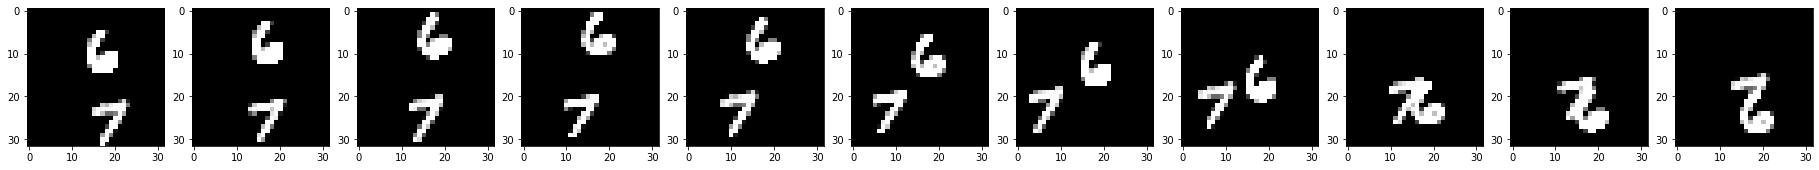

In [36]:
# Visualize the dataset to make sure the shifting and shuffling operations worked properly.
sample_idx = np.random.randint(0, len(x_train))
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_train[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(x_train[sample_idx][idx]), cmap="gray")

In [10]:
# Build a simple generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [11]:
# Get last training model.
fire_encoder = tf.keras.models.load_model('Models/MINST_Agg_01', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

# Change learning rate.
print('Old LR:',tf.keras.backend.eval(fire_encoder.optimizer.lr))
tf.keras.backend.set_value(fire_encoder.optimizer.lr, 0.0001)
print('New LR:',tf.keras.backend.eval(fire_encoder.optimizer.lr))

Old LR: 0.001
New LR: 1e-04


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights = True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose = 1)

fire_encoder.fit(train_gen,
                   epochs = 30, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = val_gen,
                   callbacks = [early_stopping, reduce_lr],
                  )

Epoch 1/30
282/282 [==============================] - 174s 593ms/step - loss: 0.1506 - MSE: 0.0370 - AUC: 0.9315 - ssim_loss: 0.7177 - psnr_loss: 85.0091 - val_loss: 0.1340 - val_MSE: 0.0338 - val_AUC: 0.9519 - val_ssim_loss: 0.7458 - val_psnr_loss: 84.8933 - lr: 1.0000e-04
Epoch 2/30
282/282 [==============================] - 167s 591ms/step - loss: 0.1410 - MSE: 0.0352 - AUC: 0.9426 - ssim_loss: 0.7087 - psnr_loss: 84.8721 - val_loss: 0.1298 - val_MSE: 0.0327 - val_AUC: 0.9554 - val_ssim_loss: 0.7125 - val_psnr_loss: 84.7371 - lr: 1.0000e-04
Epoch 3/30
282/282 [==============================] - 165s 585ms/step - loss: 0.1387 - MSE: 0.0347 - AUC: 0.9450 - ssim_loss: 0.6885 - psnr_loss: 84.8125 - val_loss: 0.1272 - val_MSE: 0.0321 - val_AUC: 0.9579 - val_ssim_loss: 0.6846 - val_psnr_loss: 84.6508 - lr: 1.0000e-04
Epoch 4/30
282/282 [==============================] - 165s 586ms/step - loss: 0.1372 - MSE: 0.0343 - AUC: 0.9466 - ssim_loss: 0.6727 - psnr_loss: 84.7722 - val_loss: 0.1255 - 

Epoch 28/30
282/282 [==============================] - ETA: 0s - loss: 0.1267 - MSE: 0.0319 - AUC: 0.9570 - ssim_loss: 0.5681 - psnr_loss: 84.4734Restoring model weights from the end of the best epoch: 21.

Epoch 28: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
282/282 [==============================] - 166s 589ms/step - loss: 0.1267 - MSE: 0.0319 - AUC: 0.9570 - ssim_loss: 0.5681 - psnr_loss: 84.4734 - val_loss: 0.1186 - val_MSE: 0.0300 - val_AUC: 0.9641 - val_ssim_loss: 0.5543 - val_psnr_loss: 84.3888 - lr: 1.0000e-08
Epoch 28: early stopping


In [13]:
fire_encoder.save('Models/MINST_Spread_01')

INFO:tensorflow:Assets written to: Models/MINST_Spread_01\assets


INFO:tensorflow:Assets written to: Models/MINST_Spread_01\assets


In [14]:
# Shuffle each dataset in unison.
# From: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_val))
np.random.shuffle(randomize)
x_val = x_val[randomize]
y_val = y_val[randomize]

In [15]:
# Build a simple generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights = True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose = 1)

fire_encoder.fit(train_gen,
                   epochs = 125, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = val_gen,
                   callbacks = [early_stopping, reduce_lr],
                  )

Epoch 1/125
282/282 [==============================] - 166s 588ms/step - loss: 0.1268 - MSE: 0.0319 - AUC: 0.9567 - ssim_loss: 0.5622 - psnr_loss: 84.4751 - val_loss: 0.1185 - val_MSE: 0.0300 - val_AUC: 0.9641 - val_ssim_loss: 0.5446 - val_psnr_loss: 84.3432 - lr: 1.0000e-09
Epoch 2/125
282/282 [==============================] - 167s 591ms/step - loss: 0.1268 - MSE: 0.0319 - AUC: 0.9567 - ssim_loss: 0.5622 - psnr_loss: 84.4751 - val_loss: 0.1185 - val_MSE: 0.0300 - val_AUC: 0.9641 - val_ssim_loss: 0.5446 - val_psnr_loss: 84.3432 - lr: 1.0000e-09
Epoch 3/125
282/282 [==============================] - 166s 590ms/step - loss: 0.1268 - MSE: 0.0319 - AUC: 0.9567 - ssim_loss: 0.5622 - psnr_loss: 84.4751 - val_loss: 0.1185 - val_MSE: 0.0300 - val_AUC: 0.9641 - val_ssim_loss: 0.5446 - val_psnr_loss: 84.3432 - lr: 1.0000e-09
Epoch 4/125
282/282 [==============================] - ETA: 0s - loss: 0.1268 - MSE: 0.0319 - AUC: 0.9567 - ssim_loss: 0.5623 - psnr_loss: 84.4751
Epoch 4: ReduceLROnPlatea

In [17]:
fire_encoder.save('Models/MINST_Spread_02')

INFO:tensorflow:Assets written to: Models/MINST_Spread_02\assets


INFO:tensorflow:Assets written to: Models/MINST_Spread_02\assets


### Making Sparse MNIST

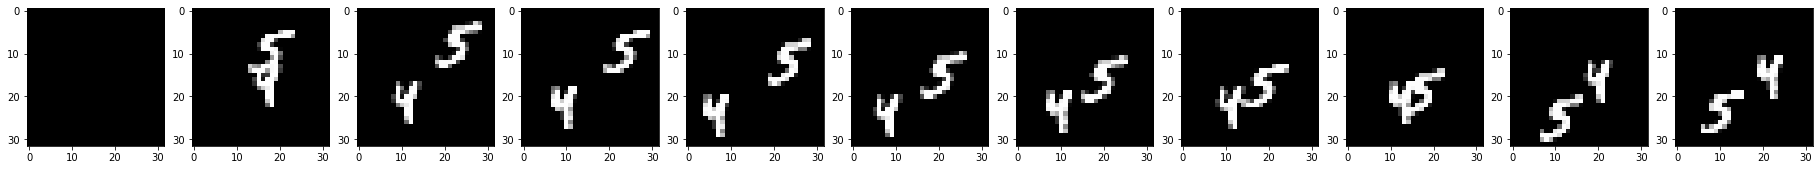

In [112]:
# Visualizing how this operation will black out some frames
sample_idx = np.random.randint(0, len(x_train))
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

sparse_x = x_train[sample_idx]
sparse_x = np.flip(sparse_x)
sparse_x = sparse_x[:np.random.randint(1,11)]
sparse_x = np.pad(sparse_x, pad_width=((0, 10 - sparse_x.shape[0]), (0, 0), (0, 0), (0, 0)), mode = 'constant')
sparse_x = np.flip(sparse_x)

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_train[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(sparse_x[idx]), cmap="gray")

In [179]:
xt_pooled, xv_pooled = [], []
r = -1

# Shuffle before sparsing.
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_val))
np.random.shuffle(randomize)
x_val = x_val[randomize]
y_val = y_val[randomize]

# Sparse up training set.
for t in range(0,len(x_train),100):
    t_x_train = x_train[t:t+100]
    t_x_train = np.flip(t_x_train)
    r += 1
    if r == 11:
        r = 0
    t_x_train = t_x_train[:,:r]
    t_x_train = np.pad(t_x_train, pad_width=((0, 0), (0, 10 - t_x_train.shape[1]), (0, 0), (0, 0), (0, 0)), mode = 'constant')
    t_x_train = np.flip(t_x_train)
    xt_pooled.append(t_x_train)
    
# Sparse up validation set.
for t in range(0,len(x_val),100):
    t_x_val = x_val[t:t+100]
    t_x_val = np.flip(t_x_val)
    r += 1
    if r == 11:
        r = 0
    t_x_val = t_x_val[:,:r]
    t_x_val = np.pad(t_x_val, pad_width=((0, 0), (0, 10 - t_x_val.shape[1]), (0, 0), (0, 0), (0, 0)), mode = 'constant')
    t_x_val = np.flip(t_x_val)
    xv_pooled.append(t_x_val)
    
# Stack
x_train = np.concatenate(xt_pooled)
x_val = np.concatenate(xv_pooled)

# Shuffle each dataset in unison.
# From: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_val))
np.random.shuffle(randomize)
x_val = x_val[randomize]
y_val = y_val[randomize]

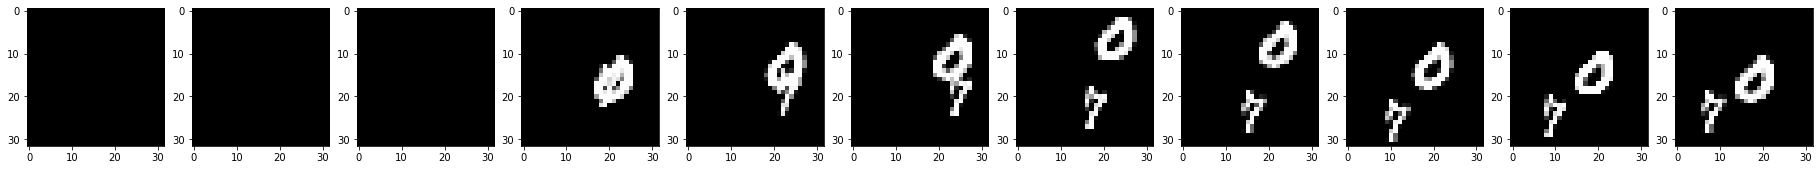

In [180]:
# Visualizing how this operation will black out some frames
sample_idx = np.random.randint(0, len(x_val2))
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(x_val[sample_idx][idx]), cmap="gray")

In [181]:
fire_encoder = tf.keras.models.load_model('Models/MINST_Agg_01', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [182]:
# Build a simple generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [185]:
# Change learning rate.
print('Old LR:',tf.keras.backend.eval(fire_encoder.optimizer.lr))
tf.keras.backend.set_value(fire_encoder.optimizer.lr, 0.000001)
print('New LR:',tf.keras.backend.eval(fire_encoder.optimizer.lr))

Old LR: 1e-05
New LR: 1e-06


In [186]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True, verbose = 1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose = 1)

fire_encoder.fit(train_gen,
                   epochs = 15, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = val_gen,
                   callbacks = [early_stopping, reduce_lr],
                  )

Epoch 1/15
282/282 [==============================] - 171s 591ms/step - loss: 0.2701 - MSE: 0.0427 - AUC: 0.8624 - ssim_loss: 0.4397 - psnr_loss: 85.3716 - val_loss: 0.2898 - val_MSE: 0.0482 - val_AUC: 0.8434 - val_ssim_loss: 0.4810 - val_psnr_loss: 86.1120 - lr: 1.0000e-06
Epoch 2/15
282/282 [==============================] - 166s 589ms/step - loss: 0.2507 - MSE: 0.0425 - AUC: 0.8649 - ssim_loss: 0.4395 - psnr_loss: 85.3370 - val_loss: 0.2673 - val_MSE: 0.0478 - val_AUC: 0.8472 - val_ssim_loss: 0.4808 - val_psnr_loss: 86.0736 - lr: 1.0000e-06
Epoch 3/15
282/282 [==============================] - 167s 591ms/step - loss: 0.2305 - MSE: 0.0422 - AUC: 0.8677 - ssim_loss: 0.4400 - psnr_loss: 85.3066 - val_loss: 0.2461 - val_MSE: 0.0475 - val_AUC: 0.8516 - val_ssim_loss: 0.4814 - val_psnr_loss: 86.0348 - lr: 1.0000e-06
Epoch 4/15
282/282 [==============================] - 167s 591ms/step - loss: 0.2134 - MSE: 0.0419 - AUC: 0.8704 - ssim_loss: 0.4421 - psnr_loss: 85.2775 - val_loss: 0.2289 - 

In [187]:
fire_encoder.save('Models/MINST_Sparse_01')

INFO:tensorflow:Assets written to: Models/MINST_Sparse_01\assets


INFO:tensorflow:Assets written to: Models/MINST_Sparse_01\assets


## Fine-Tune on VIIRS

### 2020 Validation

In [11]:
combo_model = tf.keras.models.load_model('Models/MINST_Agg_01'
                                         , custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [12]:
# Recompile model with dice loss.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = dice_coef_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [13]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')

# Combine into desired train/val split.
meta_t = pd.concat([df_2017, df_2018, df_2019]).reset_index()
meta_v = df_2020

In [14]:
# Data loaders.
batch_size = 32
#t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size, calculated_sample_weights = calculated_sample_weights[:,0])
t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size)
v_gen = data_generator(meta_v, len(meta_v), batch_size = batch_size)

In [16]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

# Train model.
combo_model.fit(t_gen, 
                   epochs = 10, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = v_gen,
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(meta_t) // batch_size,
                   validation_steps = len(meta_v) // batch_size
                  )

Epoch 1/10
468/468 [==============================] - 255s 536ms/step - loss: 0.7146 - MSE: 0.0178 - AUC: 0.7623 - ssim_loss: 0.4340 - psnr_loss: 82.3060 - val_loss: 0.6742 - val_MSE: 0.0223 - val_AUC: 0.7744 - val_ssim_loss: 0.4509 - val_psnr_loss: 83.2868 - lr: 1.0000e-05
Epoch 2/10
468/468 [==============================] - 230s 491ms/step - loss: 0.6994 - MSE: 0.0174 - AUC: 0.7278 - ssim_loss: 0.3984 - psnr_loss: 82.2023 - val_loss: 0.6641 - val_MSE: 0.0225 - val_AUC: 0.7490 - val_ssim_loss: 0.4295 - val_psnr_loss: 83.3017 - lr: 1.0000e-05
Epoch 3/10
468/468 [==============================] - 231s 495ms/step - loss: 0.6922 - MSE: 0.0176 - AUC: 0.7059 - ssim_loss: 0.3908 - psnr_loss: 82.2393 - val_loss: 0.6551 - val_MSE: 0.0227 - val_AUC: 0.7348 - val_ssim_loss: 0.4314 - val_psnr_loss: 83.3733 - lr: 1.0000e-05
Epoch 4/10
468/468 [==============================] - 231s 494ms/step - loss: 0.6868 - MSE: 0.0180 - AUC: 0.6919 - ssim_loss: 0.3864 - psnr_loss: 82.3477 - val_loss: 0.6524 - 

In [17]:
combo_model.save('Models/MNIST_FT_2020')

INFO:tensorflow:Assets written to: Models/MNIST_FT_2020\assets


INFO:tensorflow:Assets written to: Models/MNIST_FT_2020\assets


### 2019 Validation

In [18]:
combo_model = tf.keras.models.load_model('Models/MINST_Agg_01'
                                         , custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [19]:
# Recompile model with dice loss.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = dice_coef_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [20]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')

# Combine into desired train/val split.
meta_t = pd.concat([df_2017, df_2018, df_2020]).reset_index()
meta_v = df_2019

In [21]:
# Data loaders.
batch_size = 32
#t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size, calculated_sample_weights = calculated_sample_weights[:,0])
t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size)
v_gen = data_generator(meta_v, len(meta_v), batch_size = batch_size)

In [22]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

# Train model.
combo_model.fit(t_gen, 
                   epochs = 10, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = v_gen,
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(meta_t) // batch_size,
                   validation_steps = len(meta_v) // batch_size
                  )

Epoch 1/10
468/468 [==============================] - 237s 497ms/step - loss: 0.7026 - MSE: 0.0192 - AUC: 0.7789 - ssim_loss: 0.4453 - psnr_loss: 82.6045 - val_loss: 0.7044 - val_MSE: 0.0201 - val_AUC: 0.7476 - val_ssim_loss: 0.4356 - val_psnr_loss: 82.8412 - lr: 1.0000e-05
Epoch 2/10
468/468 [==============================] - 229s 490ms/step - loss: 0.6821 - MSE: 0.0192 - AUC: 0.7482 - ssim_loss: 0.4121 - psnr_loss: 82.6096 - val_loss: 0.6924 - val_MSE: 0.0203 - val_AUC: 0.7210 - val_ssim_loss: 0.4197 - val_psnr_loss: 82.8779 - lr: 1.0000e-05
Epoch 3/10
468/468 [==============================] - 230s 493ms/step - loss: 0.6763 - MSE: 0.0194 - AUC: 0.7242 - ssim_loss: 0.4014 - psnr_loss: 82.6456 - val_loss: 0.6878 - val_MSE: 0.0211 - val_AUC: 0.7080 - val_ssim_loss: 0.4209 - val_psnr_loss: 83.0710 - lr: 1.0000e-05
Epoch 4/10
468/468 [==============================] - 229s 489ms/step - loss: 0.6713 - MSE: 0.0199 - AUC: 0.7125 - ssim_loss: 0.4009 - psnr_loss: 82.7731 - val_loss: 0.6834 - 

In [23]:
combo_model.save('Models/MNIST_FT_2019')

INFO:tensorflow:Assets written to: Models/MNIST_FT_2019\assets


INFO:tensorflow:Assets written to: Models/MNIST_FT_2019\assets


### 2018 Validation

In [24]:
combo_model = tf.keras.models.load_model('Models/MINST_Agg_01'
                                         , custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [25]:
# Recompile model with dice loss.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = dice_coef_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [26]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')

# Combine into desired train/val split.
meta_t = pd.concat([df_2017, df_2019, df_2020]).reset_index()
meta_v = df_2018

In [27]:
# Data loaders.
batch_size = 32
#t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size, calculated_sample_weights = calculated_sample_weights[:,0])
t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size)
v_gen = data_generator(meta_v, len(meta_v), batch_size = batch_size)

In [28]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

# Train model.
combo_model.fit(t_gen, 
                   epochs = 10, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = v_gen,
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(meta_t) // batch_size,
                   validation_steps = len(meta_v) // batch_size
                  )

Epoch 1/10
468/468 [==============================] - 235s 493ms/step - loss: 0.7214 - MSE: 0.0234 - AUC: 0.7712 - ssim_loss: 0.4942 - psnr_loss: 83.5240 - val_loss: 0.6102 - val_MSE: 0.0101 - val_AUC: 0.8100 - val_ssim_loss: 0.2835 - val_psnr_loss: 79.8072 - lr: 1.0000e-05
Epoch 2/10
468/468 [==============================] - 230s 491ms/step - loss: 0.7049 - MSE: 0.0238 - AUC: 0.7442 - ssim_loss: 0.4700 - psnr_loss: 83.5874 - val_loss: 0.5903 - val_MSE: 0.0103 - val_AUC: 0.7886 - val_ssim_loss: 0.2680 - val_psnr_loss: 79.8926 - lr: 1.0000e-05
Epoch 3/10
468/468 [==============================] - 231s 494ms/step - loss: 0.6984 - MSE: 0.0245 - AUC: 0.7240 - ssim_loss: 0.4604 - psnr_loss: 83.7092 - val_loss: 0.5737 - val_MSE: 0.0103 - val_AUC: 0.7716 - val_ssim_loss: 0.2635 - val_psnr_loss: 79.9118 - lr: 1.0000e-05
Epoch 4/10
468/468 [==============================] - 231s 493ms/step - loss: 0.6941 - MSE: 0.0250 - AUC: 0.7109 - ssim_loss: 0.4521 - psnr_loss: 83.8035 - val_loss: 0.5729 - 

In [29]:
combo_model.save('Models/MNIST_FT_2018')

INFO:tensorflow:Assets written to: Models/MNIST_FT_2018\assets


INFO:tensorflow:Assets written to: Models/MNIST_FT_2018\assets


### 2017 Validation

In [30]:
combo_model = tf.keras.models.load_model('Models/MINST_Agg_01'
                                         , custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})

In [31]:
# Recompile model with dice loss.
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#loss_fn = tf.keras.losses.BinaryCrossentropy()
#loss_fn = tf.keras.losses.MeanSquaredError()
loss_fn = dice_coef_loss
combo_model.compile(loss=loss_fn, 
                    optimizer=opt, 
                    metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'),
                             tf.keras.metrics.AUC(name='AUC'),
                             ssim_loss,
                             psnr_loss
                            ])

In [32]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')

# Combine into desired train/val split.
meta_t = pd.concat([df_2018, df_2019, df_2020]).reset_index()
meta_v = df_2017

In [33]:
# Data loaders.
batch_size = 32
#t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size, calculated_sample_weights = calculated_sample_weights[:,0])
t_gen = data_generator(meta_t, len(meta_t), batch_size = batch_size)
v_gen = data_generator(meta_v, len(meta_v), batch_size = batch_size)

In [34]:
# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

# Train model.
combo_model.fit(t_gen, 
                   epochs = 10, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = v_gen,
                   callbacks = [early_stopping, reduce_lr],
                   steps_per_epoch = len(meta_t) // batch_size,
                   validation_steps = len(meta_v) // batch_size
                  )

Epoch 1/10
468/468 [==============================] - 235s 493ms/step - loss: 0.6805 - MSE: 0.0179 - AUC: 0.7901 - ssim_loss: 0.4194 - psnr_loss: 82.3330 - val_loss: 0.7581 - val_MSE: 0.0239 - val_AUC: 0.7125 - val_ssim_loss: 0.5013 - val_psnr_loss: 83.6081 - lr: 1.0000e-05
Epoch 2/10
468/468 [==============================] - 231s 494ms/step - loss: 0.6567 - MSE: 0.0175 - AUC: 0.7559 - ssim_loss: 0.3809 - psnr_loss: 82.2158 - val_loss: 0.7565 - val_MSE: 0.0251 - val_AUC: 0.6828 - val_ssim_loss: 0.4856 - val_psnr_loss: 83.8008 - lr: 1.0000e-05
Epoch 3/10
468/468 [==============================] - 231s 495ms/step - loss: 0.6461 - MSE: 0.0179 - AUC: 0.7361 - ssim_loss: 0.3726 - psnr_loss: 82.3525 - val_loss: 0.7572 - val_MSE: 0.0258 - val_AUC: 0.6608 - val_ssim_loss: 0.4891 - val_psnr_loss: 83.9742 - lr: 1.0000e-05
Epoch 4/10
468/468 [==============================] - 232s 495ms/step - loss: 0.6378 - MSE: 0.0181 - AUC: 0.7197 - ssim_loss: 0.3682 - psnr_loss: 82.3697 - val_loss: 0.7556 - 

In [35]:
combo_model.save('Models/MNIST_FT_2017')

INFO:tensorflow:Assets written to: Models/MNIST_FT_2017\assets


INFO:tensorflow:Assets written to: Models/MNIST_FT_2017\assets


### Testing Fire Encoder on VIIRS Fire Data

In [118]:
# Load metadata on yearly datasets.
df_2017 = pd.read_csv('4fold_super/2017/meta.csv')
df_2018 = pd.read_csv('4fold_super/2018/meta.csv')
df_2019 = pd.read_csv('4fold_super/2019/meta.csv')
df_2020 = pd.read_csv('4fold_super/2020/meta.csv')
df_2021 = pd.read_csv('4fold_super/2021/meta.csv')

# Combine into desired train/val split.
#meta_t = pd.concat([df_2018,df_2019,df_2020]).reset_index()
#meta_v = df_2017
meta_v = df_2021

In [119]:
x_train, y_train, x_val, y_val = [],[],[],[]
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features_2d)[:,:,:,:1])
    y_val.append(np.load(meta_v.iloc[x].labels))
     
x_val = np.stack(x_val)
y_val = np.stack(y_val)

x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)
y_val = np.moveaxis(y_val, 1, -1)

In [168]:
#Reload model from Phase 1.
#fire_encoder = tf.keras.models.load_model('Models/MINST_Agg_01', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})
#fire_encoder = tf.keras.models.load_model('Models/MINST_Spread_01', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})
#fire_encoder = tf.keras.models.load_model('Models/MINST_Spread_02', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss})
combo_model = tf.keras.models.load_model('Models/MNIST_FT_2019', custom_objects = {'ssim_loss': ssim_loss, 'psnr_loss': psnr_loss, 'dice_coef_loss': dice_coef_loss})

Sample Prediction Metrics:
SSIM: 0.45447179675102234 
PSNR: 0.13414253294467926 
MSE: 0.045559052 
Min Px: 5.5308714e-24 
Max Px: 0.9971494 
Mean Px: 0.022201937 
Sample ID: 1538


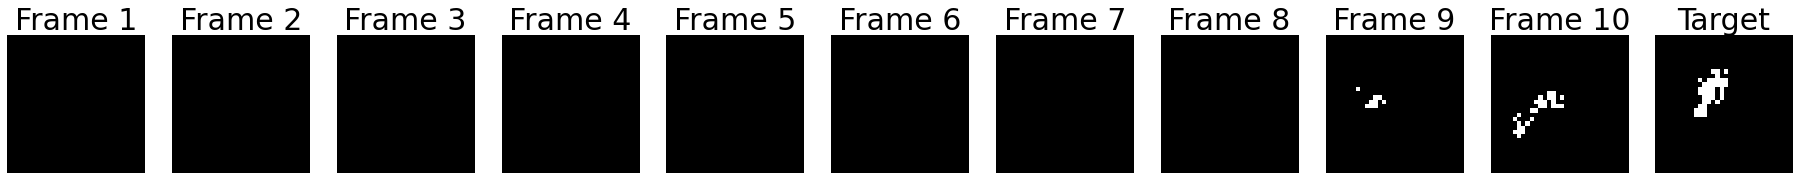

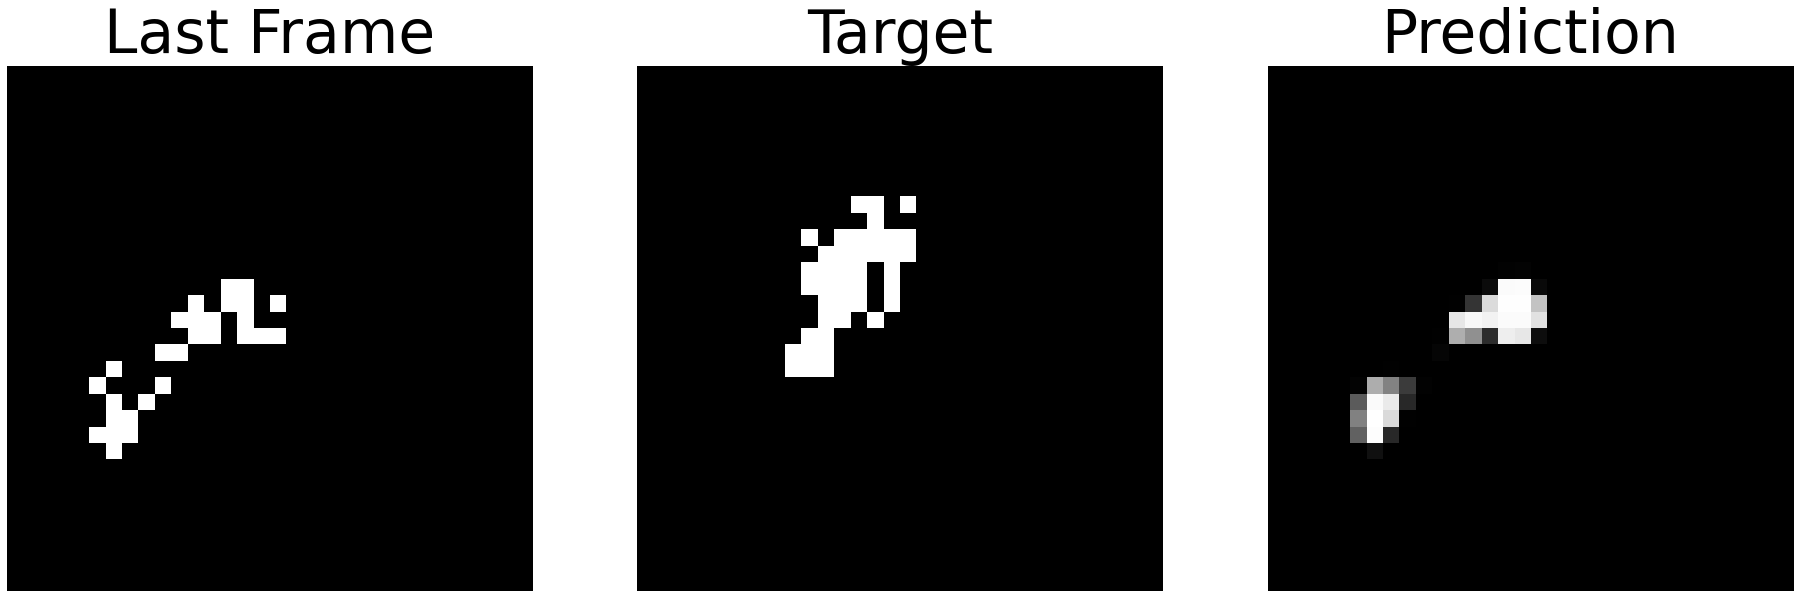

In [177]:
sample_idx = np.random.randint(0, len(x_val))

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
        ax.set_title('Target')
        ax.title.set_fontsize(30)
        ax.axis("off")
    else:
        ax.imshow(np.squeeze(x_val[sample_idx][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.title.set_fontsize(30)
        ax.axis("off")

fig, axes = plt.subplots(1, 3, figsize=(32, 16))
axes[0].imshow(np.squeeze(x_val[sample_idx][9]), cmap="gray")
axes[0].set_title('Last Frame')
axes[0].axis("off")
axes[0].title.set_fontsize(60)
axes[1].imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
axes[1].set_title('Target')
axes[1].axis("off")
axes[1].title.set_fontsize(60)
axes[2].imshow(np.squeeze(t_preds[sample_idx]), cmap="gray", vmin = 0, vmax = 1)
axes[2].set_title('Prediction')
axes[2].axis("off")
axes[2].title.set_fontsize(60)

t_preds[sample_idx].min(), t_preds[sample_idx].max(), t_preds[sample_idx].mean(),
print('Sample Prediction Metrics:'
      '\nSSIM:', float(tf.image.ssim(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0)),
      '\nPSNR:', float(tf.image.psnr(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0) / 100),
      '\nMSE:', np.mean(tf.keras.metrics.mean_squared_error(y_val[sample_idx], t_preds[sample_idx])),
      '\nMin Px:', t_preds[sample_idx].min(),
      '\nMax Px:', t_preds[sample_idx].max(),
      '\nMean Px:', t_preds[sample_idx].mean(),
      '\nSample ID:', int(sample_idx)
     )

In [122]:
# Compute and show set scores.
set_ssim = tf.image.ssim(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
set_psnr = tf.image.psnr(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
set_mse = tf.keras.metrics.mean_squared_error(y_val, t_preds)
print('Model Prediction Report')
print('SSIM:', np.mean(set_ssim))
print('PSNR:', np.mean(set_psnr) / 100)
print('MSE:', np.mean(set_mse))

Model Prediction Report
SSIM: 0.7692059
PSNR: 0.4960354232788086
MSE: 0.015924424


### Saving Predictions

In [230]:
pred_df = df_2021.copy().drop(columns=['Unnamed: 0'])
pred_df['SSIM'] = tf.image.ssim(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
pred_df['PSNR'] = tf.image.psnr(tf.cast(y_val, dtype='float32'), t_preds, 1.0)
pred_df['MSE'] = [np.mean(tf.keras.metrics.mean_squared_error(y_val[x], t_preds[x])) for x in range(0, len(t_preds))]
pred_df['Dice'] = [float(dice_coef(np.ndarray.astype(y_val[x], dtype='double'), np.ndarray.astype(t_preds[x], dtype='double'))) for x in range(0, len(t_preds))]
for x in range(0,10):
    pred_df['Day_' + str(x)] = [x_val[y][x].sum() for y in range(0,len(t_preds))]
pred_df['Day_11'] = [y_val[y].sum() for y in range(0,len(t_preds))]

pred_df

,Lon,Lat,Date,features_2d,features_1d,labels,SSIM,PSNR,MSE,Dice,...,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_11
0,-51.929966,-2.296223,2021-10-12,4fold_super/2021/features_2d/1137401.npy,4fold_super/2021/features_1d/1137401.npy,4fold_super/2021/labels/1137401.npy,0.872715,30.203493,0.000954,0.989313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
1,-51.836777,-5.699760,2021-09-14,4fold_super/2021/features_2d/1109298.npy,4fold_super/2021/features_1d/1109298.npy,4fold_super/2021/labels/1109298.npy,0.690126,19.411682,0.011451,0.894003,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
2,-55.103859,-7.571674,2021-09-14,4fold_super/2021/features_2d/1109063.npy,4fold_super/2021/features_1d/1109063.npy,4fold_super/2021/labels/1109063.npy,0.994515,30.102999,0.000977,0.990099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
3,-53.240299,-6.358397,2021-08-24,4fold_super/2021/features_2d/1090873.npy,4fold_super/2021/features_1d/1090873.npy,4fold_super/2021/labels/1090873.npy,0.478559,15.173002,0.030388,0.770367,...,0.0,0.0,2.0,11.0,25.0,24.0,16.0,32.0,35.0,31.0
4,-57.719013,-5.813770,2021-08-13,4fold_super/2021/features_2d/1065229.npy,4fold_super/2021/features_1d/1065229.npy,4fold_super/2021/labels/1065229.npy,0.677433,19.767149,0.010551,0.874634,...,2.0,2.0,4.0,4.0,1.0,0.0,13.0,26.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-55.073818,-7.503963,2021-08-10,4fold_super/2021/features_2d/1057348.npy,4fold_super/2021/features_1d/1057348.npy,4fold_super/2021/labels/1057348.npy,0.814387,18.669668,0.013584,0.890737,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,28.0,36.0,25.0
4996,-54.863297,-6.423058,2021-08-08,4fold_super/2021/features_2d/1052673.npy,4fold_super/2021/features_1d/1052673.npy,4fold_super/2021/labels/1052673.npy,0.254599,9.657280,0.108211,0.529688,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,31.0,104.0,57.0
4997,-57.092266,-5.466965,2021-09-14,4fold_super/2021/features_2d/1108556.npy,4fold_super/2021/features_1d/1108556.npy,4fold_super/2021/labels/1108556.npy,0.613548,15.340458,0.029238,0.753901,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,34.0,0.0
4998,-51.842480,-3.902443,2021-09-16,4fold_super/2021/features_2d/1112336.npy,4fold_super/2021/features_1d/1112336.npy,4fold_super/2021/labels/1112336.npy,0.783884,22.011124,0.006293,0.930332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0


In [231]:
np.save('preds/final.npy', t_preds)
pred_df.to_csv('preds/final.pd')

#### Pulling results for a specific example.

Sample Prediction Metrics:
SSIM: 0.5291383266448975 
PSNR: 0.16756099462509155 
MSE: 0.021105219 
Min Px: 1.0487438e-28 
Max Px: 0.98922974 
Mean Px: 0.0155794695


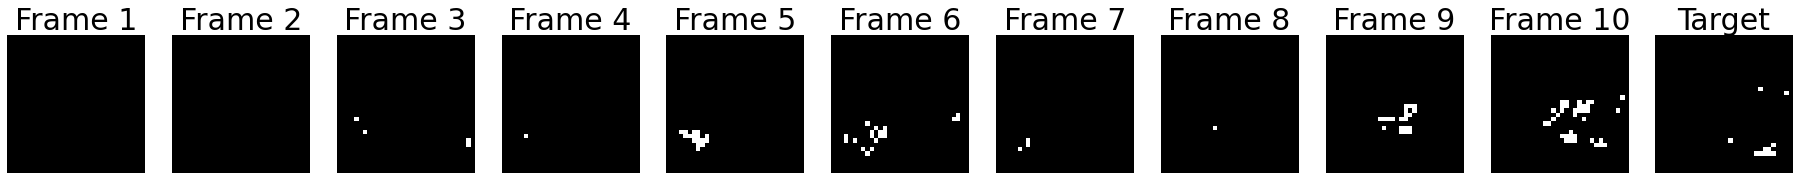

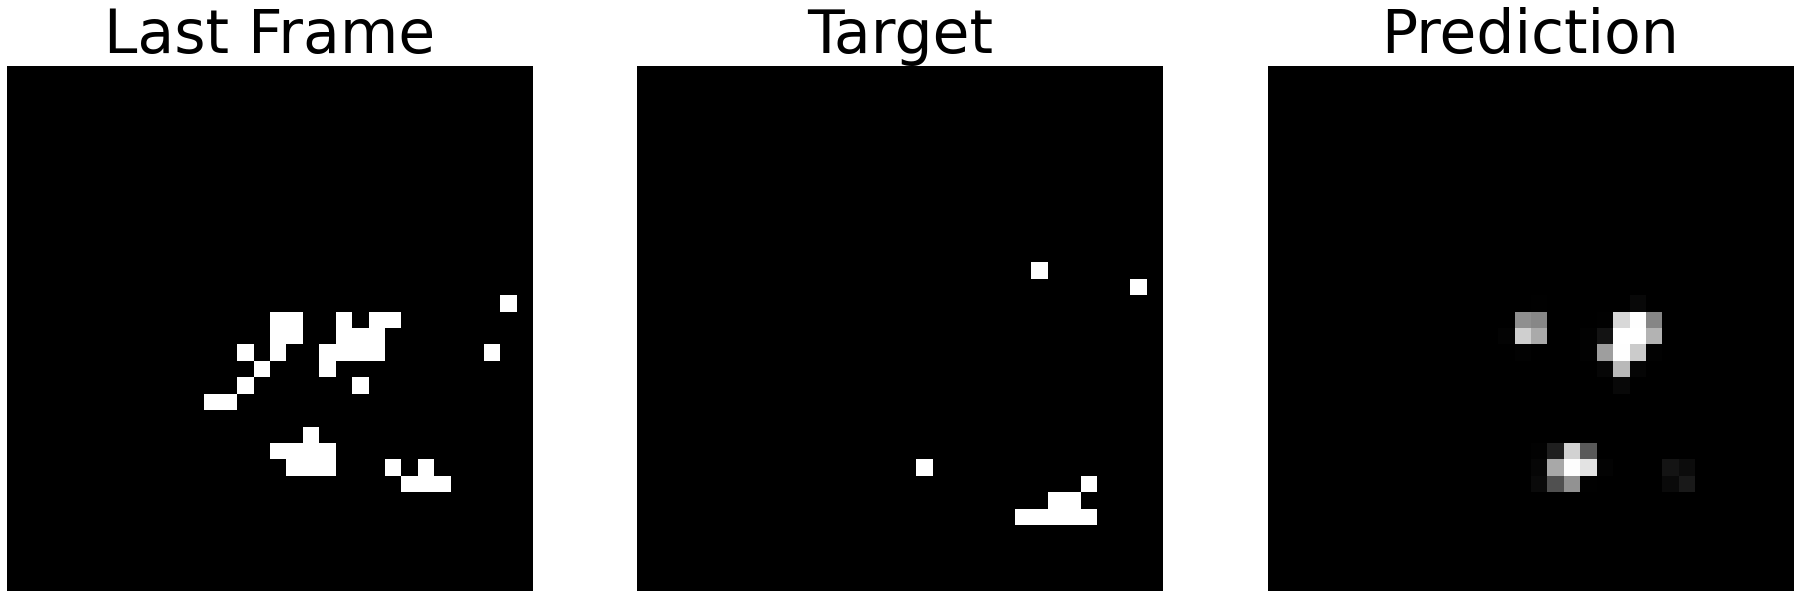

In [81]:
#sample_idx = np.random.randint(0, len(x_val))
sample_idx = 3599

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 11, figsize=(32, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes):
    if idx == 10:
        ax.imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
        ax.set_title('Target')
        ax.title.set_fontsize(30)
        ax.axis("off")
    else:
        ax.imshow(np.squeeze(x_val[sample_idx][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.title.set_fontsize(30)
        ax.axis("off")

fig, axes = plt.subplots(1, 3, figsize=(32, 16))
axes[0].imshow(np.squeeze(x_val[sample_idx][9]), cmap="gray")
axes[0].set_title('Last Frame')
axes[0].axis("off")
axes[0].title.set_fontsize(60)
axes[1].imshow(np.squeeze(y_val[sample_idx]), cmap="gray")
axes[1].set_title('Target')
axes[1].axis("off")
axes[1].title.set_fontsize(60)
axes[2].imshow(np.squeeze(t_preds[sample_idx]), cmap="gray")
axes[2].set_title('Prediction')
axes[2].axis("off")
axes[2].title.set_fontsize(60)

t_preds[sample_idx].min(), t_preds[sample_idx].max(), t_preds[sample_idx].mean(),
print('Sample Prediction Metrics:'
      '\nSSIM:', float(tf.image.ssim(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0)),
      '\nPSNR:', float(tf.image.psnr(tf.cast(y_val[sample_idx], dtype='float32'), t_preds[sample_idx], 1.0) / 100),
      '\nMSE:', np.mean(tf.keras.metrics.mean_squared_error(y_val[sample_idx], t_preds[sample_idx])),
      '\nMin Px:', t_preds[sample_idx].min(),
      '\nMax Px:', t_preds[sample_idx].max(),
      '\nMean Px:', t_preds[sample_idx].mean()
     )

### Making a gif from moving MNIST data

In [ ]:
# Inspiration: https://keras.io/examples/vision/conv_lstm/

#Download and load the dataset.
fpath = tf.keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 100 of the 10000 total examples and use those.
dataset = dataset[:100]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Shift and stack frames.
i,o = [],[]
for f in range(0,10):
    i.append(train_dataset[:,f:f+10])
    o.append(train_dataset[:,f+10:f+11])
    
x_train = np.concatenate(i)
y_train = np.squeeze(np.concatenate(o), axis=1)

i,o = [],[]
for f in range(0,10):
    i.append(val_dataset[:,f:f+10])
    o.append(val_dataset[:,f+10:f+11])
    
x_val = np.concatenate(i)
y_val = np.squeeze(np.concatenate(o), axis=1)

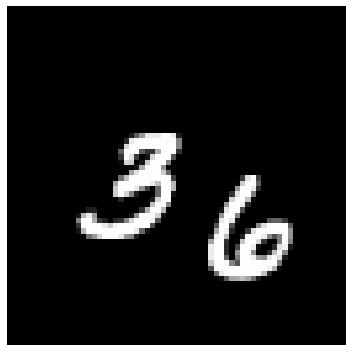

In [66]:
# Inspirtation: https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
import io
import imageio

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Get example.
gifset = list(train_dataset[40].squeeze())

# Make frames.
for i in range(0,20):
    plt.imshow(gifset[i], cmap='gray', vmin = 0, vmax = 1)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig('mnist_gif/frames/' + str(i+1) + '.png')
    
# Build gif.
with imageio.get_writer('mnist_gif/mnist.gif', mode='I') as writer:
    for filename in [('mnist_gif/frames/' + str(x+1) + '.png') for x in range(0,20)]:
        image = imageio.imread(filename)
        writer.append_data(image)